# Convolutional Autoencoder & Transfer Learning on CIFAR-10

This repository implements a **Convolutional Autoencoder (CAE)** using PyTorch. The model is trained to reconstruct images from the CIFAR-10 dataset. Subsequently, the **Encoder** part of the network is frozen and used as a feature extractor to train a classifier.

## 📌 Project Overview
1.  **Autoencoder Training**: Compresses $32 \times 32$ images into a latent space representation ($128 \times 4 \times 4$) and reconstructs them.
2.  **Transfer Learning**: The trained Encoder weights are frozen. A classification head is attached to classify images into 10 classes.
3.  **Visualization**: Comparison of original vs. reconstructed images.

## 🛠️ Architecture

### 1. The Autoencoder
The architecture follows a symmetrical Encoder-Decoder structure:
*   **Input**: $3 \times 32 \times 32$
*   **Encoder**: 3 Conv2d layers with BatchNorm and ReLU. Compresses input to $128 \times 4 \times 4$.
*   **Decoder**: 3 ConvTranspose2d layers. Reconstructs output to $3 \times 32 \times 32$.

### 2. The Classifier
*   **Input**: Latent features from the frozen Encoder ($128 \times 4 \times 4$).
*   **Layers**: Flatten -> Linear(2048, 256) -> Dropout(0.3) -> Linear(256, 10).

## 🚀 Installation & Usage

### Prerequisites
```bash
pip install torch torchvision matplotlib numpy
```

### Running the Code
Run the main script to train the autoencoder, train the classifier, and visualize results:
```bash
python main.py
```

## 📊 Results

### 1. Training Loss
The Autoencoder was trained for **20 epochs** using MSE Loss.
*(Insert your loss_curve.png here)*

### 2. Reconstruction Quality
Below is a comparison of Original images (Top) vs. Reconstructed images (Bottom) from the test set.
![Reconstruction Results](results/reconstruction.png)
*(Note: You need to save the plot generated by your code to display it here)*

### 3. Classification Accuracy
After freezing the encoder and training the classifier head for 15 epochs:
*   **Test Accuracy**: `54.10%`



## 📝 Future Improvements
*   Train for more epochs to lower reconstruction loss.
*   Use a deeper architecture (ResNet backbone) for better accuracy.
*   Implement Data Augmentation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:02<00:00, 63.0MB/s]


In [ ]:
image,_ = next(iter(train_loader))
image.shape

torch.Size([64, 3, 32, 32])

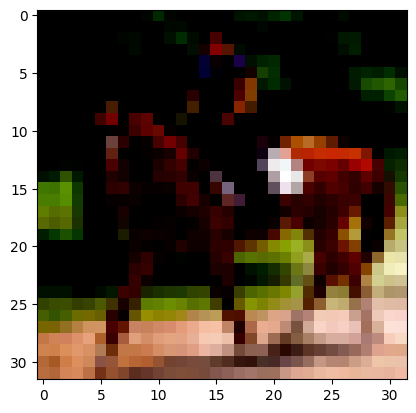

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image[1].permute(1,2,0), cmap = 'gray')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 32×16×16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64×8×8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 128×4×4
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1),  # 64×8×8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),   # 32×16×16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 3, stride=2, output_padding=1, padding=1),   # 3×32×32
            nn.Tanh()
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
model = ConvAutoencoder().to(device)

In [ ]:
model.state_dict()

OrderedDict([('enc.0.weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                        [ 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses = []
stepi = []
global_step = 0

model.train()
print("\n==== TRAINING AUTOENCODER ====\n")

for epoch in range(epochs):
    epoch_loss = 0

    for imgs, _ in train_loader:
        outputs = model(imgs.to(device))
        loss = criterion(outputs, imgs.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        train_losses.append(loss.item())
        stepi.append(global_step)
        global_step += 1

    print(f"Epoch [{epoch+1}/{epochs}] | Avg Batch Loss: {epoch_loss/len(train_loader):.6f}")

100%|██████████| 170M/170M [00:04<00:00, 40.1MB/s]



==== TRAINING AUTOENCODER ====

Epoch [1/20] | Avg Batch Loss: 0.026048
Epoch [2/20] | Avg Batch Loss: 0.010377
Epoch [3/20] | Avg Batch Loss: 0.008256
Epoch [4/20] | Avg Batch Loss: 0.007189
Epoch [5/20] | Avg Batch Loss: 0.006113
Epoch [6/20] | Avg Batch Loss: 0.005423
Epoch [7/20] | Avg Batch Loss: 0.005318
Epoch [8/20] | Avg Batch Loss: 0.004744
Epoch [9/20] | Avg Batch Loss: 0.004573
Epoch [10/20] | Avg Batch Loss: 0.004279
Epoch [11/20] | Avg Batch Loss: 0.004126
Epoch [12/20] | Avg Batch Loss: 0.003968
Epoch [13/20] | Avg Batch Loss: 0.003864
Epoch [14/20] | Avg Batch Loss: 0.003667
Epoch [15/20] | Avg Batch Loss: 0.003606
Epoch [16/20] | Avg Batch Loss: 0.003394
Epoch [17/20] | Avg Batch Loss: 0.003417
Epoch [18/20] | Avg Batch Loss: 0.003150
Epoch [19/20] | Avg Batch Loss: 0.003127
Epoch [20/20] | Avg Batch Loss: 0.003020


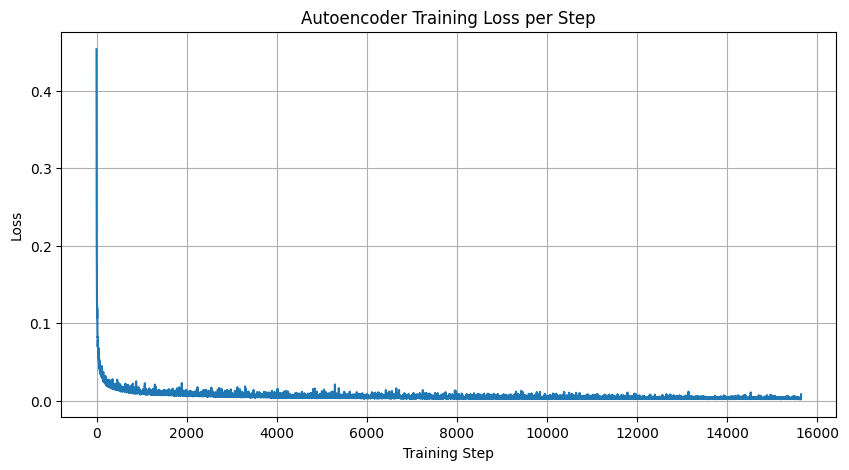

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(stepi, train_losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss per Step")
plt.grid(True)
plt.show()


In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder.enc

        # Freeze encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)

In [ ]:
clf = Classifier(model).to(device)

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, clf.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 15
print("\n=== TRAINING CLASSIFIER WITH FROZEN ENCODER ===\n")
clf.train()
for epoch in range(epochs):
    running_loss = 0
    for img, labels in train_loader:
        img, labels = img.to(device), labels.to(device)

        outputs = clf(img)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Classifier Loss: {running_loss/len(train_loader):.4f}")


=== TRAINING CLASSIFIER WITH FROZEN ENCODER ===

Epoch [1/15] Classifier Loss: 0.9691
Epoch [2/15] Classifier Loss: 0.9491
Epoch [3/15] Classifier Loss: 0.9396
Epoch [4/15] Classifier Loss: 0.9236
Epoch [5/15] Classifier Loss: 0.9060
Epoch [6/15] Classifier Loss: 0.8888
Epoch [7/15] Classifier Loss: 0.8821
Epoch [8/15] Classifier Loss: 0.8694
Epoch [9/15] Classifier Loss: 0.8540
Epoch [10/15] Classifier Loss: 0.8449
Epoch [11/15] Classifier Loss: 0.8385
Epoch [12/15] Classifier Loss: 0.8174
Epoch [13/15] Classifier Loss: 0.8146
Epoch [14/15] Classifier Loss: 0.8054
Epoch [15/15] Classifier Loss: 0.8001


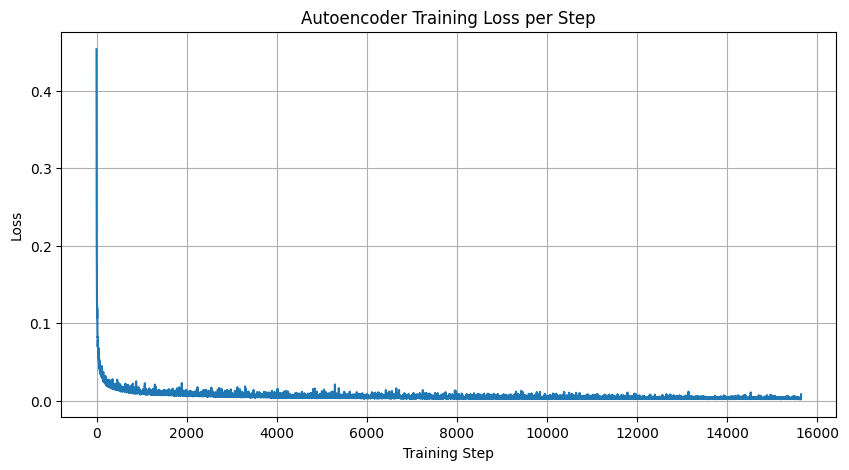

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(stepi, train_losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss per Step")
plt.grid(True)
plt.show()

In [ ]:
correct = 0
total = 0

clf.eval()
with torch.no_grad():
    for img, labels in test_loader:
        img, labels = img.to(device), labels.to(device)
        outputs = clf(img)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nAccuracy on Test Set: {100 * correct / total:.2f}%")


Accuracy on Test Set: 54.10%


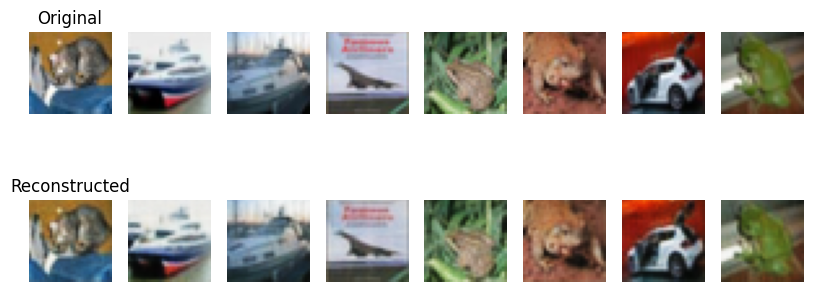

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


model.eval()

images, _ = next(iter(test_loader))

with torch.no_grad():
    reconstructed = model(images.to(device))

def imshow(img):
    if isinstance(img, torch.Tensor) and img.is_cuda:
        img = img.cpu()
    img = img.numpy().transpose(1, 2, 0)
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")


num_images = 8
plt.figure(figsize=(10, 4))

for i in range(num_images):

    plt.subplot(2, num_images, i + 1)
    imshow(images[i])
    if i == 0:
        plt.title("Original")

    plt.subplot(2, num_images, i + 1 + num_images)
    imshow(reconstructed[i])
    if i == 0:
        plt.title("Reconstructed")

plt.show()